In [16]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from keras.models import Model, Input
from keras.preprocessing import image
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
import glob
import warnings
warnings.filterwarnings('ignore')

**6.1 Data Preparation**

**_5.1 Data Preparation**

In [26]:
# List all filename in face image path
filenames = glob.glob('face_mini/**/*.jpg', recursive=True)

# Load image files and Resize (h,w,ch) -> h = w < 100 , ch = 3 (R,G,B)
# Convert the image to an array
# Normalized color image
all_images = []
for i in filenames[:100]:
    img = image.load_img(i, target_size=(80,80,3), interpolation="nearest")
    img = image.img_to_array(img)
    img = img / 255
    all_images.append(img)

# Convert to numpy array
all_images = np.array(all_images)
print(all_images.shape)

# split data into train and validation data
train_x, test_x = train_test_split(all_images, random_state=32, test_size=0.3)
train_x, val_x = train_test_split(train_x, random_state=32, test_size=0.3)

(100, 80, 80, 3)


**_5.2 Add noise**

In [18]:
# Add Noise
#   Scala between 0-1
noise_factor = 0.2 # 0-1

# กำหนด noise parameter
Nmean = 0
Nstd = 1

# Use np.random.normal to generate normal distribution (gaussian) noise
x_train_noisy = train_x + (noise_factor * np.random.normal(loc=Nmean, scale=Nstd, size=train_x.shape))

x_val_noisy = val_x + (noise_factor * np.random.normal(loc=Nmean, scale=Nstd, size=val_x.shape))

x_test_noisy = test_x + (noise_factor * np.random.normal(loc=Nmean, scale=Nstd, size=test_x.shape))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


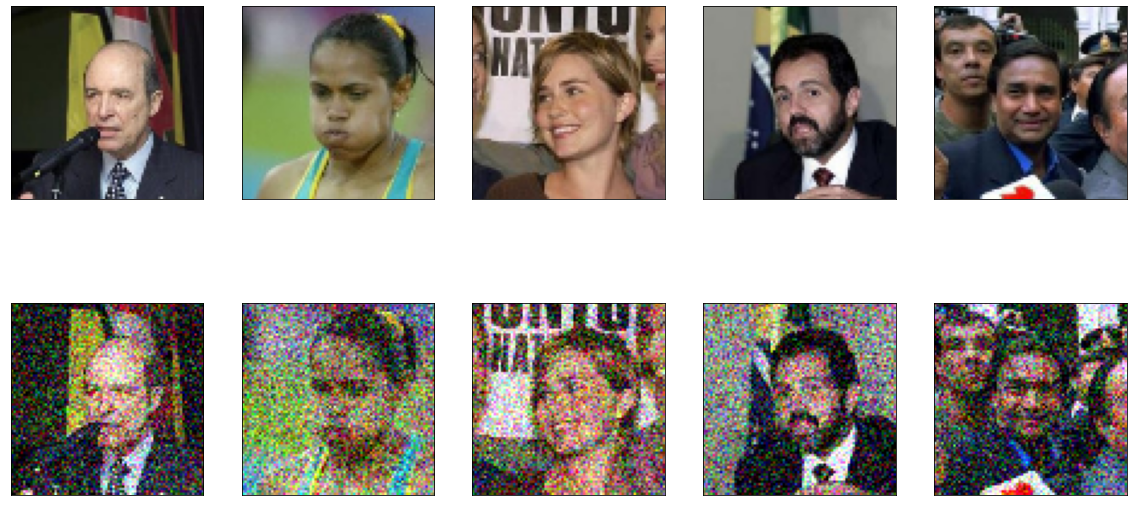

In [19]:
n = 5
plt.figure(figsize= (20,10))

for i in range(n):
  ax = plt.subplot(2, n, i+1)
  plt.imshow(val_x[i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  ax = plt.subplot(2, n, i+1+n)
  plt.imshow(x_val_noisy[i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.savefig('act5_2.png', facecolor="white", transparent=True)
plt.show()

**6.2 create_model** (Autoencoder)

In [20]:
#Create_model function
def create_model(optimizer='adam'):
    Input_img = Input(shape=(80, 80, 3))

    x1 = Conv2D(256,(3,3), activation='relu',padding='same')(Input_img)
    x2 = Conv2D(128,(3,3), activation='relu',padding='same')(x1)
    x2 = MaxPool2D((2,2))(x2)
    encoded = Conv2D(64,(3,3), activation='relu', padding='same')(x2)

    x3 = Conv2D(64,(3,3), activation='relu', padding='same')(encoded)
    x3 = UpSampling2D((2,2))(x3)
    x4 = Conv2D(128,(3,3), activation='relu', padding='same')(x3)
    x5 = Conv2D(256,(3,3), activation='relu', padding='same')(x4)

    decoded = Conv2D(3,(3,3), padding='same')(x5)

    autoencoder = Model(Input_img, decoded)
    autoencoder.compile(optimizer=optimizer, loss='mse',metrics=['mse'])
    # autoencoder.summary()
    return autoencoder

model = KerasRegressor(build_fn=create_model,epochs=2,batch_size=16,verbose=0)

**6.3 Hyperparameter Tuning** (GridSearchCV(), RandomizedSearchCV())

**6.3 (a) Create GridSearchCV()**

In [21]:
# กำหนด Grid Search parameters
optimizer = ['SGD','RMSprop','Adadelta','Adam']
batch_size = [8,16,32]
epochs = [2,4,6]
param_grid = dict(batch_size=batch_size,epochs=epochs,optimizer=optimizer)

In [ ]:
grid_ = GridSearchCV(   estimator=model,
                        # n_jobs=-1,
                        verbose=0,
                        cv=2,
                        # random_state=10,
                        param_grid= param_grid,)

grid_result = grid_.fit(x_train_noisy,train_x)

In [41]:
print('Best params: ',grid_result.best_params_)
print('Best score: ', grid_result.best_score_)
print()

df_means = grid_result.cv_results_['mean_test_score']
df_stds = grid_result.cv_results_['std_test_score']
df_params = grid_result.cv_results_['params']

for mean, stdev, param in zip(df_means, df_stds, df_params):
  print("%f (%f) with: %r" %(mean,stdev,param))

Best params:  {'batch_size': 8, 'epochs': 6, 'optimizer': 'Adam'}
Best score:  -0.019281821325421333

-0.166850 (0.013428) with: {'batch_size': 8, 'epochs': 2, 'optimizer': 'SGD'}
-0.062706 (0.007784) with: {'batch_size': 8, 'epochs': 2, 'optimizer': 'RMSprop'}
-0.211798 (0.007790) with: {'batch_size': 8, 'epochs': 2, 'optimizer': 'Adadelta'}
-0.052133 (0.008930) with: {'batch_size': 8, 'epochs': 2, 'optimizer': 'Adam'}
-0.115519 (0.023085) with: {'batch_size': 8, 'epochs': 4, 'optimizer': 'SGD'}
-0.045860 (0.008504) with: {'batch_size': 8, 'epochs': 4, 'optimizer': 'RMSprop'}
-0.210460 (0.007908) with: {'batch_size': 8, 'epochs': 4, 'optimizer': 'Adadelta'}
-0.021683 (0.001939) with: {'batch_size': 8, 'epochs': 4, 'optimizer': 'Adam'}
-0.067556 (0.023359) with: {'batch_size': 8, 'epochs': 6, 'optimizer': 'SGD'}
-0.024029 (0.001163) with: {'batch_size': 8, 'epochs': 6, 'optimizer': 'RMSprop'}
-0.209300 (0.008163) with: {'batch_size': 8, 'epochs': 6, 'optimizer': 'Adadelta'}
-0.019282 (

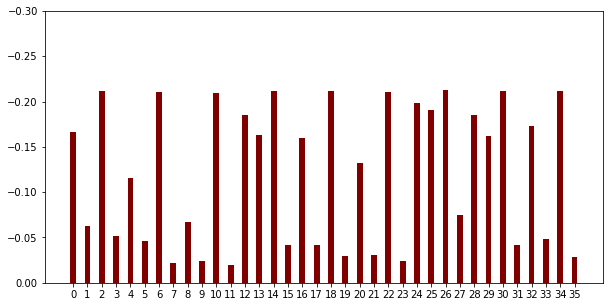

In [45]:
fig = plt.figure(figsize = (10, 5))

idx = []
for i in range(len(df_means)):
  idx.append(str(i))
 
# creating the bar plot
plt.bar(idx, df_means, color ='maroon',
        width = 0.4)

plt.ylim([0,-0.3])
plt.show()

**6.3 (b) Create RandomizedSearchCV()**

In [ ]:
#กำหนด Grid Search parameters
random_search = {'optimizer':['SGD','RMSprop','Adadelta','Adam'],
                'batch_size': list(np.linspace(8,64,5,dtype=int)),
                'epochs': list(np.linspace(1,10,4,dtype=int))}

grid_rand = RandomizedSearchCV( estimator=model,
                                verbose=0,
                                cv=2,
                                random_state=10,
                                n_iter=10,
                                param_distributions=random_search,)

grid_rand_result = grid_rand.fit(x_train_noisy,train_x)

In [43]:
print('Best params: ',grid_rand_result.best_params_)
print('Best score: ', grid_rand_result.best_score_)
print()

means = grid_rand_result.cv_results_['mean_test_score']
stds = grid_rand_result.cv_results_['std_test_score']
params = grid_rand_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" %(mean,stdev,param))

Best params:  {'optimizer': 'RMSprop', 'epochs': 4, 'batch_size': 22}
Best score:  -0.045229630544781685

-0.056700 (0.017215) with: {'optimizer': 'RMSprop', 'epochs': 7, 'batch_size': 36}
-0.211158 (0.007595) with: {'optimizer': 'Adadelta', 'epochs': 10, 'batch_size': 36}
-0.210575 (0.007703) with: {'optimizer': 'Adadelta', 'epochs': 7, 'batch_size': 22}
-0.205678 (0.007629) with: {'optimizer': 'SGD', 'epochs': 1, 'batch_size': 36}
-0.052611 (0.000098) with: {'optimizer': 'Adam', 'epochs': 1, 'batch_size': 36}
-323.742233 (12.471909) with: {'optimizer': 'RMSprop', 'epochs': 1, 'batch_size': 64}
-0.045230 (0.003581) with: {'optimizer': 'RMSprop', 'epochs': 4, 'batch_size': 22}
-0.075106 (0.033099) with: {'optimizer': 'Adam', 'epochs': 1, 'batch_size': 8}
-0.162548 (0.004037) with: {'optimizer': 'RMSprop', 'epochs': 4, 'batch_size': 36}
-0.079104 (0.001338) with: {'optimizer': 'Adam', 'epochs': 1, 'batch_size': 22}


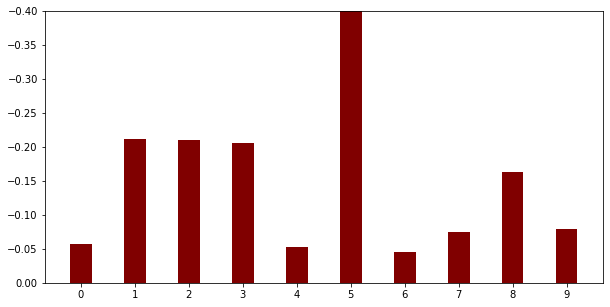

In [44]:
fig = plt.figure(figsize = (10, 5))

idx = []
for i in range(len(means)):
  idx.append(str(i))
 
# creating the bar plot
plt.bar(idx, means, color ='maroon',
        width = 0.4)

plt.ylim([0,-0.4])
plt.show()